## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from utils.prepare_data import prepare_short_data, prepare_full_data
from environment import Environment
from models.base_model import Base_model
from models.DQN import DQN

from datetime import timedelta, datetime
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from models.TD import ActorModel, CriticModel, ActorImprovedValue, CriticTD, critic_epoch, actor_epoch
import torch
from tqdm import tqdm
import numpy as np

## Constants

In [2]:
df = prepare_full_data('data/Data_RU.xlsx')

In [3]:
env = Environment(data=df[df.Date < datetime(2022, 2, 1)], stock_name='AFKS', initial_money=1000)
env.data.head()

,Date,Weekday,AFKS_close,AFKS_high,AFKS_low,AFKS_open,AFKS_volume,AFKS_D1,AFKS_D2,AFKS_D3,AFKS_D4
21,2018-02-01,3,12.265,12.265,12.105,12.140,10856600.0,0.011667,0.010297,0.010297,0.002891
22,2018-02-02,4,12.000,12.365,11.960,12.265,15760300.0,0.070244,-0.021606,0.008153,0.025502
24,2018-02-06,1,11.460,11.785,11.420,11.700,24278300.0,0.016949,-0.020513,0.007265,0.024518
26,2018-02-08,3,11.505,11.720,11.475,11.560,8508300.0,-0.061688,-0.004758,0.013841,0.007407
29,2018-02-13,1,12.320,12.715,12.250,12.660,19482300.0,0.033469,-0.026856,0.004344,0.033469


In [4]:
start_date = env.first_date()

## DQN

In [5]:
# 15 is random nummber in [10, days_count] here
dqn = DQN(env.observation_tensor(15).shape[0], 3, env, batch_size=32)
dqn.fit()

100%|██████████| 10000/10000 [02:24<00:00, 69.25it/s]


In [6]:
env.reset()
for i in range(10, env.day_count-1):
    obs = env.observation_tensor(i)
    action = dqn.predict(obs)
    
    reward = env.reward(i, action)
    state = env.observation_tensor(i)
#     model.fit(state, action, reward)
    
    env.transition(i, action)

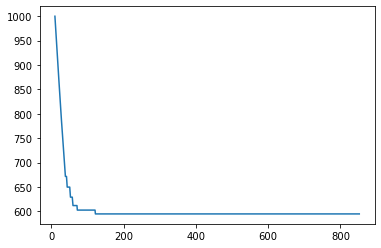

In [7]:
plt.plot(range(10, env.day_count), env.money)

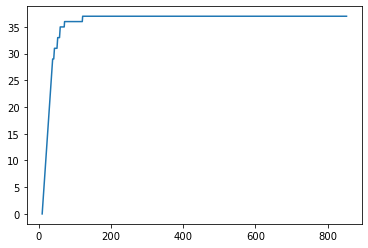

In [8]:
plt.plot(range(10, env.day_count), env.stocks)

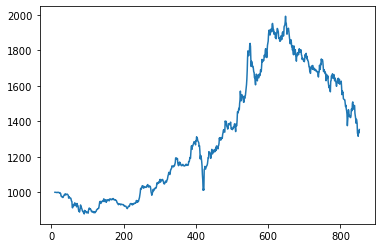

In [9]:
plt.plot(range(10, env.day_count), env.total_cost())

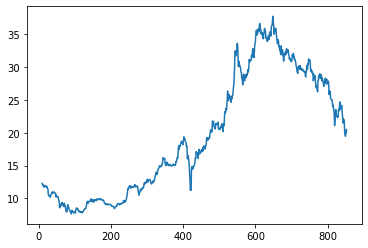

In [10]:
plt.plot(range(10, env.day_count), env.stock_cost())

### Add more stocks to train on

In [11]:
env = Environment(data=df, stock_name='AFKS', initial_money=1000)
dqn = DQN(env.observation_tensor(15).shape[0],
          3,
          env,
          batch_size=128)
for s in ['AFKS', 
          'SBER',
          'YNDX',
#           'GAZP'
         ]:
    state = dqn.state_dict()
    env = Environment(data=df, stock_name=s, initial_money=1000)
    dqn.fit(state)

100%|██████████| 10000/10000 [03:45<00:00, 44.33it/s]


## Testing

In [12]:
test_env = Environment(data=df, stock_name='SBER', initial_money=1000)
# test_env = Environment(data=df, stock_name='AFKS', initial_money=1000)

In [13]:
test_env.reset()
for i in range(10, test_env.day_count-1):
    obs = test_env.observation_tensor(i)
    action = dqn.predict(obs)
    
    reward = test_env.reward(i, action)
    state = test_env.observation_tensor(i)
#     model.fit(state, action, reward)
    
    test_env.transition(i, action)

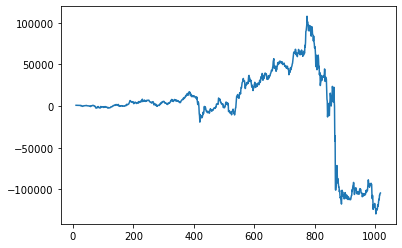

In [14]:
plt.plot(range(10, test_env.day_count), test_env.total_cost())

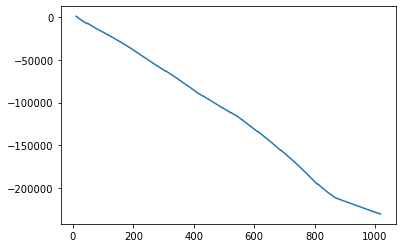

In [15]:
plt.plot(range(10, test_env.day_count), test_env.money)

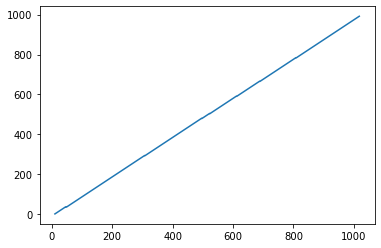

In [16]:
plt.plot(range(10, test_env.day_count), test_env.stocks)

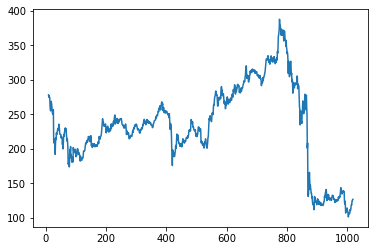

In [17]:
plt.plot(range(10, test_env.day_count), test_env.stock_cost())

## TD model

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

actor = ActorModel(
    actor_in_size=env.observation_tensor(15).shape[0],
    actor_layer_size=128).to(device)
critic = CriticModel(
    critic_in_size=env.observation_tensor(15).shape[0], 
                    critic_layer_size=128).to(device)

critic_temporal_difference = CriticTD(actor, critic, env).to(device)
actor_improved_value = ActorImprovedValue(actor, critic, env).to(device)

In [19]:
optimizer_critic_kind = torch.optim.Adam
optimizer_critic_parameters = {
    'lr': 5e-6,
    'weight_decay': 1e-5
}

optimizer_actor_kind = torch.optim.Adam
optimizer_actor_parameters = {
    "lr" : 1e-4,
    "weight_decay" : 1e-5
}

critic_iterations = 2000
critic_batch_size = 32

actor_iterations = 2000
actor_batch_size = 32

epochs = 5

Actor-Critic learning:   0%|          | 0/5 [00:00<?, ?it/s]

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 21919558.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 87.36234283447266


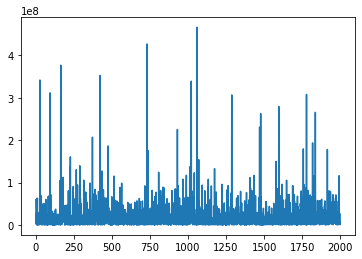

Actor-Critic learning:  20%|██        | 1/5 [05:00<20:00, 300.15s/it]

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 23478628.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 22.9627742767334


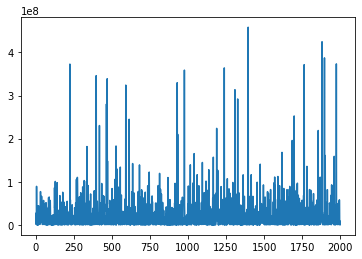

Actor-Critic learning:  40%|████      | 2/5 [10:01<15:02, 300.72s/it]

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 23449852.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 74.49781036376953


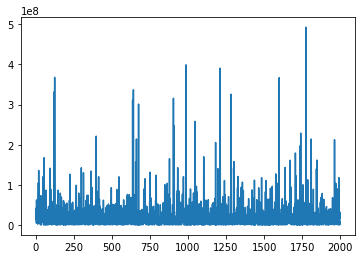

Actor-Critic learning:  60%|██████    | 3/5 [15:08<10:07, 303.58s/it]

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 24156996.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 81.67440795898438


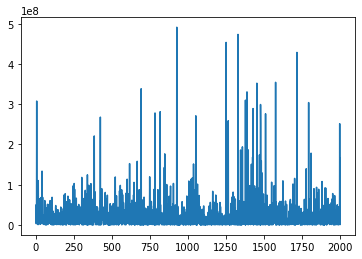

Actor-Critic learning:  80%|████████  | 4/5 [20:11<05:03, 303.32s/it]

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 24281748.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 52.715450286865234


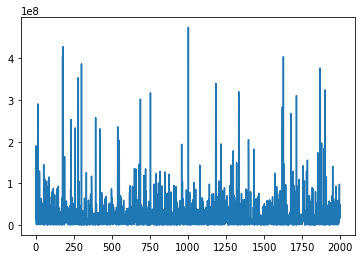

In [21]:
optimizer_actor = optimizer_actor_kind(actor_improved_value.parameters(), **optimizer_actor_parameters)

for _ in tqdm(range(epochs), "Actor-Critic learning", leave=False):
    optimizer_critic = optimizer_critic_kind(critic_temporal_difference.parameters(), **optimizer_critic_parameters)
    losses = np.array(critic_epoch(optimizer_critic,
                                   critic_temporal_difference,
                                   critic_iterations,
                                   env,
                                   actor_batch_size))
    actor_epoch(optimizer_actor,
                actor_improved_value,
                actor_iterations,
                env,
                actor_batch_size)
    plt.plot(losses)
    plt.show()

In [ ]:
test_env = Environment(data=df, stock_name='SBER', initial_money=1000)

In [ ]:
test_env.reset()
for i in range(10, test_env.day_count-1):
    obs = test_env.observation_tensor(i)
    action = torch.argmax(actor(obs))
    -1
    
    reward = test_env.reward(i, action)
    state = test_env.observation_tensor(i)
    
    test_env.transition(i, action)

In [ ]:
plt.plot(range(10, test_env.day_count), test_env.total_cost())

In [ ]:
plt.plot(range(10, test_env.day_count), test_env.money)

In [ ]:
plt.plot(range(10, test_env.day_count), test_env.stocks)